In [1]:
# file-handling
import os 

# user status updates
import time
from time import gmtime, strftime
from tqdm import tqdm
from IPython.display import display, Latex
from datetime import datetime

# the holy trinity of python data science
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# scipy
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad

# torch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# parallelization, memory management
from joblib import Parallel, delayed
from numba import jit, njit, prange
import copy

# itertools
import itertools

############ Macros ###############
np.random.seed(0)
torch.manual_seed(0)

# Physical constants
N = 10 # number of fermions
J = 100 # ~"energy scale" of couplings
Q_COUPLING = 3 # order of coupling, don't want to use the letter 'Q' because that denotes the supercharge
N_DIM = 2**N # Hilbert space dimension 
FIRST_NONZERO = 0.15 # first nonzero eigenvalue, for our intents and purposes

# Computer stuff
N_SAMPLES = 50 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel

# Model stuff
LR = 1e-5 # learning rate
BATCH_SIZE = 20 # batch size for training the neural network
N_EPOCHS = 5 # number of epochs to train the neural network
R_TRAIN = 0.5 # desired ratio of zero eigenvalues to total eigenvalues IN TRAINING SET
RUN_COUNTER = 0 # counter for how many times we've trained the model for N_EPOCHS

# Directories
N2_SUSY_DIR = os.path.join("Excel", "N2_SUSY_SYK")
RESULT_DIR = os.path.join(N2_SUSY_DIR, "Simulated Hamiltonians", f"N{N}_J{J}")
MLP_DIR = os.path.join(N2_SUSY_DIR, "CNN", f"N{N}_J{J}")
os.makedirs(MLP_DIR, exist_ok=True)

# 1. Data

##       1.1 Load data

In [2]:
N_IV = N_SAMPLES*N_DIM
ivals_all = np.zeros(shape=(N_IV,), dtype=np.float64)
ivecs_all = np.zeros(shape=(N_IV, N_DIM), dtype=np.complex128)

for i in range(N_SAMPLES):
    ivals_i = np.load(os.path.join(RESULT_DIR, f"ivals_{i}.npy"))
    ivecs_i = np.load(os.path.join(RESULT_DIR, f"ivecs_{i}.npy"))
    ivals_all[i*N_DIM:(i+1)*N_DIM] = ivals_i
    ivecs_all[i*N_DIM:(i+1)*N_DIM,:] = ivecs_i

labels_all = (ivals_all>=FIRST_NONZERO).astype(int) # zero-energy eigenvectors labeled with 0, finite-energy eigenvectors labeled with 1
print(f"ivals_all.shape: {ivals_all.shape}")
print(f"ivecs_all.shape: {ivecs_all.shape}")
print(f"labels_all.shape: {labels_all.shape}")

ivals_all.shape: (102400,)
ivecs_all.shape: (102400, 1024)
labels_all.shape: (102400,)


## 1.2 Convert (1xN_DIM) complex into (1xN_DIMx2) real

Torch doesn't currently have handling for complex numbers

In [3]:
ivecs_all_new = np.zeros(shape=(N_IV, 2, N_DIM), dtype=np.float64)

for i in range(N_IV):
    ivecs_all_i = ivecs_all[i]
    ivecs_all_new[i,0,:] = ivecs_all_i.real
    ivecs_all_new[i,1,:] = ivecs_all_i.real

ivecs_all = ivecs_all_new
del ivecs_all_new

print(f"ivecs_all.shape = {ivecs_all.shape}")

ivecs_all.shape = (102400, 2, 1024)


## 1.3 Train-test-validate split

In [4]:
# first, random shuffle
shuffler = np.random.permutation(N_IV)
ivecs_all = ivecs_all[shuffler]
labels_all = labels_all[shuffler]

p_train = 0.7
n_train = int(p_train*N_IV)
X_train = ivecs_all[:n_train]
y_train = labels_all[:n_train]

p_val = 0.2
n_val = int(p_val*N_IV)
X_val = ivecs_all[n_train:n_train+n_val]
y_val = labels_all[n_train:n_train+n_val]

p_test = 0.1
n_test = int(p_test*N_IV)
X_test = ivecs_all[n_train+n_val:]
y_test = labels_all[n_train+n_val:]

### 1.3.1 Balance training set

$r_{train} = $ desired proportion of zero-energy eigenvectors

$N_0 =$ number of zero-energy eigenvectors

$N_f =$ number of finite-energy eigenvectors

$N_{add}$ number of zero-energy eigenvectors we must add to achieve $r_{want}$



   :


To find $N_{add}$, we start off with an identity:

$r_{train} \equiv \frac{N_0+N_{add}}{N_0+N_f+N_{add}} $

$N_0+N_{add} = r_{train} (N_0+N_f+N_{add})$

$N_0+N_{add} = r_{train}*N_0+r_{train}*N_f+r_{train}*N_{add}$

$N_{add}(1-r_{train}) = N_0(r_{train}-1)+r_{train}*N_f$


And finally,

$N_{add} = \frac{N_0(r_{train}-1)+N_f*r_{train}}{1-r_{train}}$

In [5]:
N_0 = sum(y_train==0)
N_f = sum(y_train==1)
N_add = (N_0*(R_TRAIN-1)+N_f*R_TRAIN)/(1-R_TRAIN)

X_train_0 = X_train[y_train==0]
X_train_0_clone_idx = np.random.choice(range(X_train_0.shape[0]), size=int(N_add), replace=True)
X_train_0_clone = copy.deepcopy(X_train_0[X_train_0_clone_idx])
y_train_0_clone = np.zeros(shape=(X_train_0_clone.shape[0],), dtype=np.int32)

X_train = np.concatenate((X_train, X_train_0_clone), axis=0)
y_train = np.concatenate((y_train, y_train_0_clone), axis=0)

print(f"X_train.shape: {X_train.shape}")
print(f"N_0: {sum(y_train==0)/len(y_train)}")


X_train.shape: (98138, 2, 1024)
N_0: 0.5


## 1.4 Convert to Torch tensors that MLP can read

In [6]:
X_train = torch.from_numpy(X_train).float().cuda()
y_train = torch.from_numpy(y_train).float().cuda()

X_val = torch.from_numpy(X_val).float().cuda()
y_val = torch.from_numpy(y_val).float().cuda()

X_test = torch.from_numpy(X_test).float().cuda()
y_test = torch.from_numpy(y_test).float().cuda()

# 2. CNN

In [7]:
X_i = X_train[0:3]
print(f"X_i.shape: {X_i.shape}")

X_i.shape: torch.Size([3, 2, 1024])


In [8]:
conv1 = nn.Conv1d(2, 2, N_DIM//4, stride=1)
conv1.cuda()
X1 = conv1(X_i)
print(f"X1.shape: {X1.shape}")

X1.shape: torch.Size([3, 2, 769])


In [9]:
class BinaryClassifierCNN(nn.Module):
    '''
        Contains two hidden layers. ReLU activation for hidden layers, sigmoid for output layer.

    '''
    # Initialize layers and dropout with corresponding dimensions.
    def __init__(self):
        
        super(BinaryClassifierCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(2, 1, N_DIM//4, stride=1)
        #self.conv2 = nn.Conv1d(2, 2, N_DIM//8, stride=1)
        #self.conv3 = nn.Conv1d(2, 1, N_DIM//16, stride=2)
        #self.fc1 = nn.Linear(290, 100)
        #self.fc2 = nn.Linear(100, 10)
        #self.fc3 = nn.Linear(10, 1)
        self.fc1 = nn.Linear(769, 300)
        self.fc2 = nn.Linear(300, 20)
        self.fc3 = nn.Linear(20, 1)


    # Function to pass data forward through network.
    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        # out2 = F.relu(self.conv2(out1))
        # out3 = F.relu(self.conv3(out2))
        # out4 = F.relu(self.fc1(out3))
        # out5 = F.relu(self.fc2(out4))
        # out6 = F.sigmoid(self.fc3(out5))
        
        # return torch.squeeze(out6, axis=1)

        out2 = F.relu(self.fc1(out1))
        out3 = F.relu(self.fc2(out2))
        out4 = F.sigmoid(self.fc3(out3))
        return torch.squeeze(out4, axis=1)

# Initialize model and random model 
model = BinaryClassifierCNN()
model.cuda()

model_random = BinaryClassifierCNN()
model_random.cuda()

RUN_COUNTER = 0 # If you re-instantiate the models, must restart the run counter

In [10]:
X_out = model(X_i)
print(f"X_out.shape = {X_out.shape}")

X_out.shape = torch.Size([3, 1])


# 3. Train

## 3.1 Define training function

In [11]:
def train(model, optimizer, loss_func, X_train, y_train, X_val, y_val, batch_size, n_epochs):
    train_loss_list = []
    validation_acc_list = []
    n_batch = X_train.shape[0]//batch_size

    tic = time.time()
    for i in tqdm(range(n_epochs)):
        # shuffle samples
        shuffler = np.random.permutation(X_train.shape[0])
        X_train = X_train[shuffler]
        y_train = y_train[shuffler]

        optimizer.zero_grad()

        train_loss_i = []
        val_acc_i = []

        for j in range(n_batch):
            X_i = X_train[j*batch_size:(j+1)*batch_size]
            y_i = y_train[j*batch_size:(j+1)*batch_size]

            # Forward pass
            output = torch.squeeze(model(X_i))
            loss = loss_func(output, y_i)
            train_loss_i.append(loss.item())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                # Validation accuracy
                output_val = torch.squeeze(model(X_val))
                output_val = torch.round(output_val)
                val_acc_i.append((output_val == y_val).sum().item()/y_val.shape[0])

        train_loss_list.extend(train_loss_i)
        validation_acc_list.extend(val_acc_i)
    
    duration = time.time() - tic
    print(f"Training: {duration//60} minutes, {duration%60} seconds")
    return train_loss_list, validation_acc_list

## 3.2 Train model

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_func = torch.nn.BCELoss()
train_loss_list, val_acc_list = train(model, optimizer, loss_func, X_train, y_train, X_val, y_val, BATCH_SIZE, 1)#N_EPOCHS)
RUN_COUNTER += 1/N_EPOCHS

100%|██████████| 1/1 [04:53<00:00, 293.56s/it]

Training: 4.0 minutes, 53.56183362007141 seconds


## 3.3 Train model further with smaller learning rate 

In [13]:
#later = """
optimizer = torch.optim.Adam(model.parameters(), lr=LR/10)
train_loss_list_2, val_acc_list_2 = train(model, optimizer, loss_func, X_train, y_train, X_val, y_val, BATCH_SIZE, 1)#N_EPOCHS)
RUN_COUNTER += 1/N_EPOCHS

train_loss_list.extend(train_loss_list_2)
val_acc_list.extend(val_acc_list_2)#"""

100%|██████████| 1/1 [04:54<00:00, 294.09s/it]

Training: 4.0 minutes, 54.09485340118408 seconds


## 3.4 Train model further with even smaller learning rate

In [14]:
#later = """
optimizer = torch.optim.Adam(model.parameters(), lr=LR/100)
train_loss_list_3, val_acc_list_3 = train(model, optimizer, loss_func, X_train, y_train, X_val, y_val, BATCH_SIZE, 1)#N_EPOCHS)
RUN_COUNTER += 1/N_EPOCHS

train_loss_list.extend(train_loss_list_3)
val_acc_list.extend(val_acc_list_3)#"""

100%|██████████| 1/1 [04:54<00:00, 294.10s/it]

Training: 4.0 minutes, 54.103707790374756 seconds


# 4. Evaluation

## 4.1 Plot loss, validation accuracy

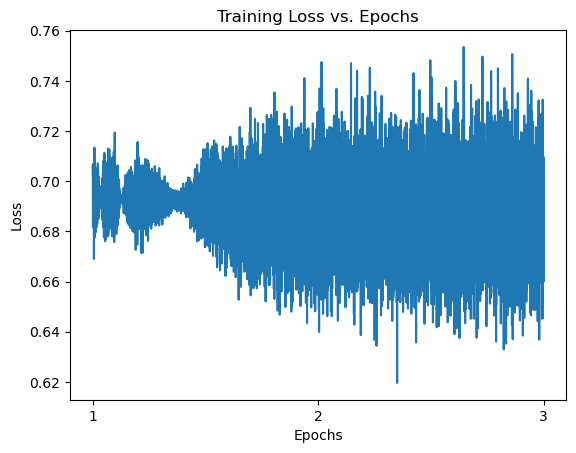

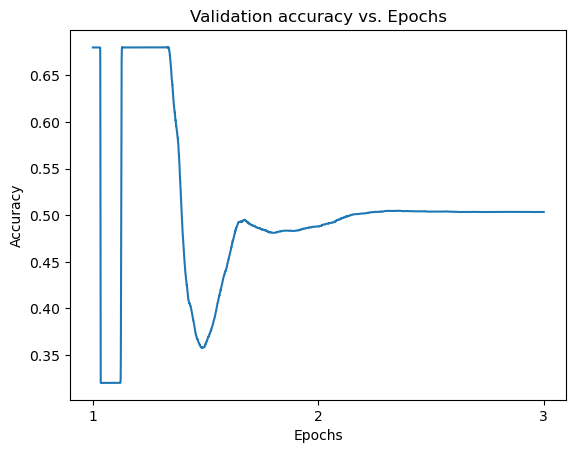

In [15]:
plt.figure()
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.xticks(ticks=np.linspace(0, len(train_loss_list), int(N_EPOCHS*RUN_COUNTER)), labels=[f"{i+1}" for i in range(int(N_EPOCHS*RUN_COUNTER))])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.show()
plt.close()

plt.figure()
plt.plot(range(len(val_acc_list)), val_acc_list)
plt.ylabel("Accuracy")
plt.xticks(ticks=np.linspace(0, len(train_loss_list), int(N_EPOCHS*RUN_COUNTER)), labels=[f"{i+1}" for i in range(int(N_EPOCHS*RUN_COUNTER))])
plt.xlabel("Epochs")
plt.title("Validation accuracy vs. Epochs")
plt.show()
plt.close()

## 4.2 Evaluate performance on test-set

In [16]:
with torch.no_grad():
    output_test = torch.squeeze(model(X_test))
    output_test = torch.round(output_test)
    
def get_metrics(y_pred, y_true):
    true_pos = sum((y_pred==y_true)&(y_pred==1))
    true_neg = sum((y_pred==y_true)&(y_pred==0))
    false_pos = sum((y_pred!=y_true)&(y_pred==1))
    false_neg = sum((y_pred!=y_true)&(y_pred==0))

    acc = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
    prec = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    f1 = 2*prec*recall/(prec+recall)
    return acc, prec, recall, f1

acc, prec, recall, f1 = get_metrics(output_test, y_test)
p_pos_pred = sum(output_test==1)/len(output_test)
p_pos_true = sum(y_test==1)/len(y_test)

print(f"Test accuracy: {100*acc:.2f}%")
print(f"Test precision: {100*prec:.2f}%")
print(f"Test recall: {100*recall:.2f}%")
print(f"Test F1 score: {f1:.2f}")
print(f"\n\nProportion of predictions that are positive: {100*p_pos_pred:.2f}%")
print(f"Proportion of truth-labels that are positive: {100*p_pos_true:.2f}%")

Test accuracy: 49.88%
Test precision: 76.42%
Test recall: 38.68%
Test F1 score: 0.51


Proportion of predictions that are positive: 34.63%
Proportion of truth-labels that are positive: 68.42%


## 4.3 Compute monte-carlo p-values of model's performance (controlling for the same proportion of predicted positives)

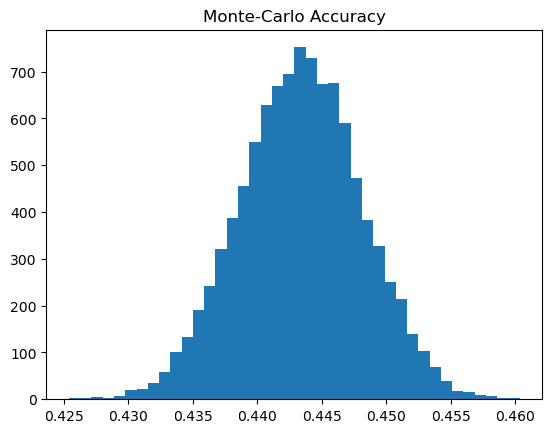

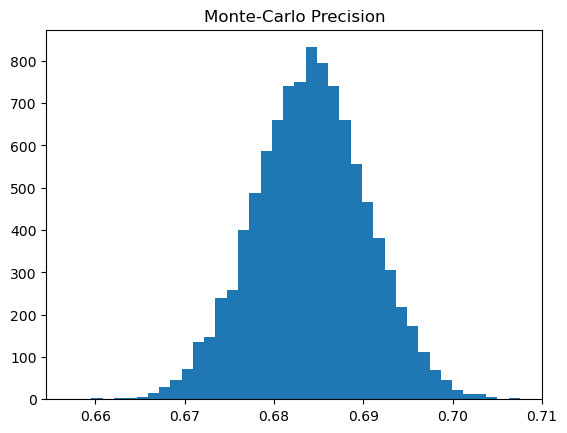

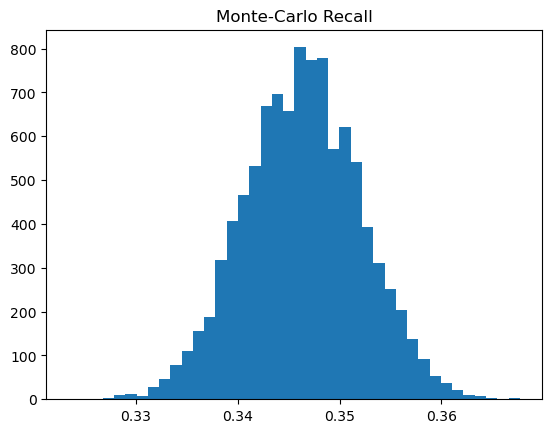

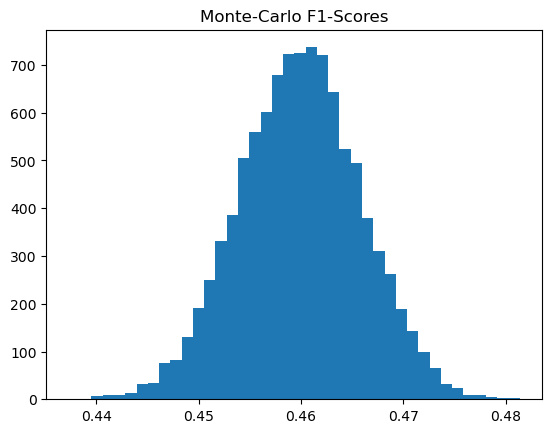

Duration: 1.0 minutes, 5.196371793746948 seconds
Accuracy: (49.88%, p=0.00010)
Precision: (76.42%, p=0.00010)
Recall: (38.68%, p=0.00010)
F1: (51.36%, p=0.00010)


In [17]:
PLOTS = True
VARY_P_POS = None

def monte_carlo_bin_pred(y_truth, p_pos_pred, n_mc_samples, vary_p_pos): # generates random binary monte-carlo predictions, with the given probability of a positive prediction
    mc_predictions = np.zeros(shape=(n_mc_samples, len(y_truth)))
    for i in range(n_mc_samples):
        if vary_p_pos:
            p_pos_pred_i = np.random.choice(np.linspace(max(0, p_pos_pred-vary_p_pos), min(p_pos_pred+vary_p_pos,1), 100), size=1)[0]
            pred_i = np.random.choice([0, 1], size=len(y_truth), p=[1-p_pos_pred_i, p_pos_pred_i])
        else:
            pred_i = np.random.choice([0, 1], size=len(y_truth), p=[1-p_pos_pred, p_pos_pred])
        mc_predictions[i] = pred_i
    return mc_predictions


def monte_carlo_performance(y_truth, p_pos_pred, n_mc_samples, plots, vary_p_pos): # Computes monte-carlo performance metrics for a given probability of a positive prediction
    mc_predictions = monte_carlo_bin_pred(y_truth, p_pos_pred, n_mc_samples, vary_p_pos)

    acc = np.zeros(shape=(n_mc_samples))
    prec = np.zeros(shape=(n_mc_samples))
    recall = np.zeros(shape=(n_mc_samples))
    f1 = np.zeros(shape=(n_mc_samples))
    for i in range(n_mc_samples):
        acc[i], prec[i], recall[i], f1[i] = get_metrics(mc_predictions[i], y_truth) 

    if plots:
        plt.figure()
        plt.hist(acc, bins=40)
        plt.title("Monte-Carlo Accuracy")
        plt.show()
        plt.close()

        plt.figure()
        plt.hist(prec, bins=40)
        plt.title("Monte-Carlo Precision")
        plt.show()
        plt.close()

        plt.figure()
        plt.hist(recall, bins=40)
        plt.title("Monte-Carlo Recall")
        plt.show()
        plt.close()

        plt.figure()
        plt.hist(f1, bins=40)
        plt.title("Monte-Carlo F1-Scores")
        plt.show()
        plt.close()


    return acc, prec, recall, f1
    

def get_performance(y_pred, y_truth, p_pos_pred, n_mc_samples=1000, plots=False, vary_p_pos=None): # Computes performance metric of given predictions, and the monte-carlo p-values of those metrics
    acc, prec, recall, f1 = get_metrics(y_pred, y_truth)
    mc_acc, mc_prec, mc_recall, mc_f1 = monte_carlo_performance(y_truth, p_pos_pred, n_mc_samples, plots, vary_p_pos)

    p_acc = (np.sum(acc < mc_acc)+1)/(n_mc_samples+1)
    p_prec = (np.sum(prec < mc_prec)+1)/(n_mc_samples+1)
    p_recall = (np.sum(recall < mc_recall)+1)/(n_mc_samples+1)
    p_f1 = (np.sum(f1 < mc_f1)+1)/(n_mc_samples+1)

    performance_dict = {"Accuracy": (acc, p_acc),
                        "Precision": (prec, p_prec),
                        "Recall": (recall, p_recall),
                        "F1": (f1, p_f1)}
    return performance_dict

tic = time.time()
performance_dict = get_performance(output_test.cpu().numpy(), y_test.cpu().numpy(), p_pos_pred.item(), n_mc_samples=10000, plots=PLOTS, vary_p_pos=VARY_P_POS)
duration = time.time() - tic
print(f"Duration: {duration//60} minutes, {duration%60} seconds")   

for key, value in performance_dict.items():
    print(f"{key}: ({100*value[0]:.2f}%, p={value[1]:.5f})")


## 4.4 Compare to randomly-trained model

In [ ]:
#torch.cuda.empty_cache()

# Create random labels for training random model
shuffler = np.random.permutation(y_train.shape[0])
y_train_random = y_train[shuffler]

# Train random model
#later = """
optimizer_random = torch.optim.Adam(model_random.parameters(), lr=LR)
loss_func = torch.nn.BCELoss()
train_loss_list_random, val_acc_list_random = train(model_random, optimizer_random, loss_func, X_train, y_train_random, X_val, y_val, BATCH_SIZE, 2*N_EPOCHS)
#"""

#later = """
# Train random model again with smaller learning rate
optimizer_random = torch.optim.Adam(model_random.parameters(), lr=LR/10)
train_loss_list_random_2, val_acc_list_random_2 = train(model_random, optimizer_random, loss_func, X_train, y_train_random, X_val, y_val, BATCH_SIZE, 3*N_EPOCHS)
train_loss_list_random.extend(train_loss_list_random_2)
val_acc_list_random.extend(val_acc_list_random_2) 
#"""

#later = """
# Train random model again with even smaller learning rate
optimizer_random = torch.optim.Adam(model_random.parameters(), lr=LR/100)
train_loss_list_random_3, val_acc_list_random_3 = train(model_random, optimizer_random, loss_func, X_train, y_train_random, X_val, y_val, BATCH_SIZE, 2*N_EPOCHS)
train_loss_list_random.extend(train_loss_list_random_3)
val_acc_list_random.extend(val_acc_list_random_3)
#"""

## Plot loss, validation accuracy
plt.figure()
plt.plot(range(len(train_loss_list_random)), train_loss_list_random)
plt.ylabel("Loss")
plt.xticks(ticks=np.linspace(0, len(train_loss_list), N_EPOCHS*RUN_COUNTER), labels=[f"{i+1}" for i in range(N_EPOCHS*RUN_COUNTER)])
plt.xlabel("Epochs")
plt.title("Random Model: Training Loss vs. Epochs")
plt.show()
plt.close()

plt.figure()
plt.plot(range(len(val_acc_list_random)), val_acc_list_random)
plt.ylabel("Accuracy")
plt.xticks(ticks=np.linspace(0, len(train_loss_list), N_EPOCHS*RUN_COUNTER), labels=[f"{i+1}" for i in range(N_EPOCHS*RUN_COUNTER)])
plt.xlabel("Epochs")
plt.title("Random Model: Validation Accuracy vs. Epochs")
plt.show()
plt.close()

## Evaluate on test-set
with torch.no_grad():
    output_test_random = torch.squeeze(model_random(X_test))
    output_test_random = torch.round(output_test_random)
acc_random, prec_random, recall_random, f1_random = get_metrics(output_test_random, y_test)
p_pos_pred_random = sum(output_test_random==1)/len(output_test_random)

print(f"Test accuracy random: {100*acc_random:.2f}%")
print(f"Test precision random: {100*prec_random:.2f}%")
print(f"Test recall random: {100*recall_random:.2f}%")
print(f"Test F1 score random: {f1_random:.2f}")
print(f"\n\nProportion of predictions that are positive: {100*p_pos_pred_random:.2f}%")
print(f"Proportion of truth-labels that are positive: {100*p_pos_true:.2f}%")

## Compute monte carlo values
tic = time.time()
performance_dict_random = get_performance(output_test_random.cpu().numpy(), y_test.cpu().numpy(), p_pos_pred.item(), n_mc_samples=10000, plots=PLOTS, vary_p_pos=VARY_P_POS)
duration = time.time() - tic
print(f"Monte Carlo: {duration//60} minutes, {duration%60} seconds")

for key, value in performance_dict_random.items():
    print(f"{key}: ({100*value[0]:.2f}%, p={value[1]:.5f})")

# 5. Save model and about.txt

In [ ]:
prev_runs = [i for i in os.listdir(MLP_DIR) if ".pt" in i]
if len(prev_runs) == 0:
    max_run = 0
else:
    max_run = int(prev_runs[-1].replace(".pt", "")[-1])
RUN_PATH = os.path.join(MLP_DIR, f"run_{max_run+1}.pt")
torch.save(model.state_dict(), RUN_PATH)

RUN_ABOUT_PATH = RUN_PATH.replace(".pt", ".txt")
with open(RUN_ABOUT_PATH, "w") as f:
    f.write(f"N: {N}\nJ: {J}\nFIRST_NONZERO: {FIRST_NONZERO}") # physical constants
    f.write(f"\nModel: {model._modules}\nN_SAMPLES: {N_SAMPLES}\nR_TRAIN: {R_TRAIN}\nN_EPOCHS: {N_EPOCHS*RUN_COUNTER}\nLR: {LR}\nBATCH_SIZE: {BATCH_SIZE}") # model parameters
    f.write(f"\n\nPerformance: P_POS_TRUE={p_pos_true}\n  Accuracy: {acc}\n  Precision: {prec}\n  Recall: {recall}\n  F1: {f1}\n P_POS_PRED: {p_pos_pred}") # model performance
    f.write(f"\n\nPerformance of random model\n  Accuracy: {acc_random}\n  Precision: {prec_random}\n  Recall: {recall_random}\n  F1: {f1_random}\n P_POS_PRED: {p_pos_pred_random}") # random model performance
    f.write("\n\nPerformance p-values:")
    f.write(f"\nVARY_P_POS: {VARY_P_POS}")
    for k, v in performance_dict.items():
        f.write(f"\n  {k}: ({100*v[0]:.2f}%, p={v[1]})")
    #later="""
    f.write("\n\nPerformance p-values RANDOM MODEL:")
    f.write(f"\nVARY_P_POS: {VARY_P_POS}")
    for k, v in performance_dict_random.items():
        f.write(f"\n  {k}: ({100*v[0]:.2f}%, p={v[1]})")#"""